In [1]:
import sqlite3
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



In [2]:
conn = sqlite3.connect("Monitoring.db")
df = pd.read_sql("SELECT * FROM RuntimeData;", conn)
df.head()

,Timestamp,Zone,Value
0,01.01.2023 01:00,Zone1,22.034781
1,01.01.2023 02:00,Zone1,21.983360
2,01.01.2023 03:00,Zone1,21.895082
3,01.01.2023 04:00,Zone1,21.777768
4,01.01.2023 05:00,Zone1,21.637705


In [3]:
df.info()
df.describe()
df["Zone"].unique()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35036 entries, 0 to 35035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  35036 non-null  object 
 1   Zone       35036 non-null  object 
 2   Value      35036 non-null  float64
dtypes: float64(1), object(2)
memory usage: 821.3+ KB


array(['Zone1', 'Zone2', 'Zone3', 'Zone4'], dtype=object)

In [4]:
df["Value"].describe()


count    35036.000000
mean        18.018469
std          4.644259
min          9.977620
25%         11.309834
50%         21.000000
75%         21.000000
max         24.690487
Name: Value, dtype: float64

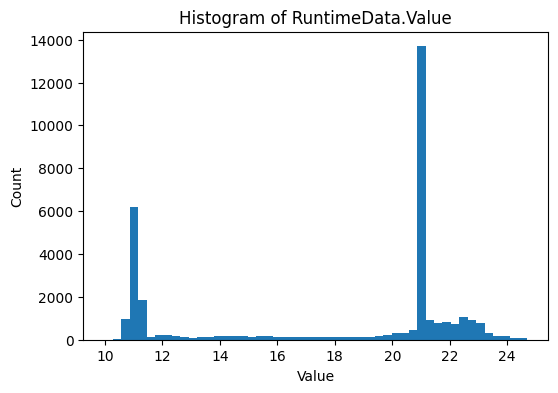

In [5]:
values = pd.to_numeric(df["Value"], errors="coerce").dropna().to_numpy(dtype=float)
values = values[np.isfinite(values)]  # just in case

edges = np.linspace(values.min(), values.max(), 51)
counts, _ = np.histogram(values, bins=edges)

centers = 0.5 * (edges[:-1] + edges[1:])
widths  = edges[1:] - edges[:-1]

plt.figure(figsize=(6,4))
plt.bar(centers, counts, width=widths)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of RuntimeData.Value")
plt.show()


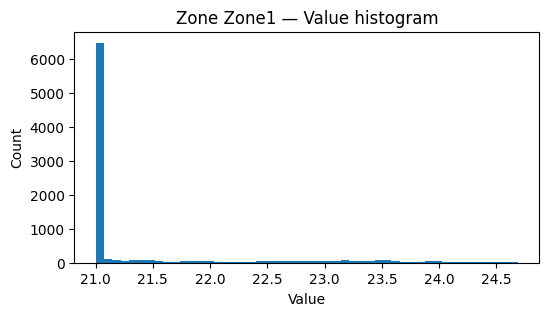

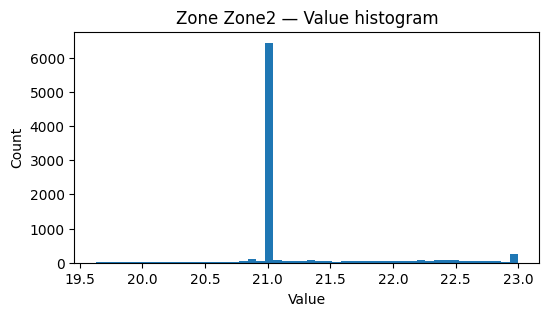

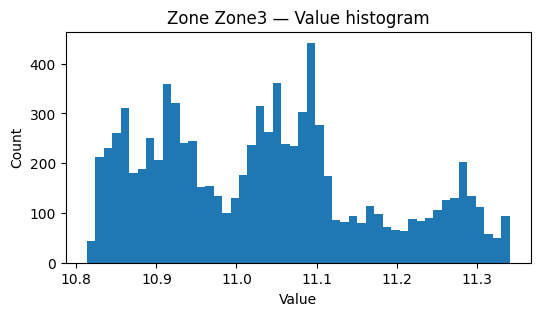

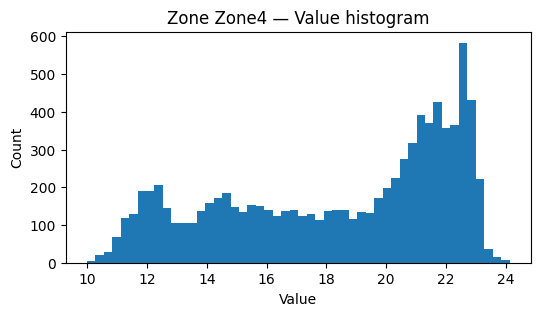

In [6]:
for z in df["Zone"].unique():
    v = pd.to_numeric(df.loc[df["Zone"] == z, "Value"], errors="coerce").dropna().to_numpy(dtype=float)
    v = v[np.isfinite(v)]
    if len(v) < 2:
        continue

    edges = np.linspace(v.min(), v.max(), 51)
    counts, _ = np.histogram(v, bins=edges)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths  = edges[1:] - edges[:-1]

    plt.figure(figsize=(6,3))
    plt.bar(centers, counts, width=widths)
    plt.title(f"Zone {z} — Value histogram")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()
